In [1]:
#import
import sys
sys.path.append("/Users/mac/Desktop/project/")
from enum import Enum
import itertools
import pygame
import snakes.plugins
from sortedcontainers import SortedList, SortedSet, SortedDict
from orderedset import OrderedSet
from learning.modules.process_mining.alpha_miner import AlphaMiner , Relations
snakes.plugins.load('gv', 'snakes.nets', 'nets')
from nets import *
#just for the notebook
from IPython.display import Image
import pandas as pd

In [2]:
class Alpha_plus(AlphaMiner):
    def __init__(self ,Traces):
        super().__init__(Traces)
        #traces within an event log
        self.traces = Traces
        # set of transitions that appear in loop of length one
        self.L1L = None
        # T' , traces minus L1L
        self.T_pr = None
        self.F_L1L = None
        self.Wm_L1L = SortedDict()
        self.alphaObject = None
    

    def extractRelations(self):
            #Extract non repetitive traces, alpha dont take care  about  frequencies !
        nnrep_traces = SortedSet()
        for trace in self.traces.values():
            nnrep_traces.add("".join(trace))
        print(nnrep_traces)
        #Extract relations between each transitions
        # generate Footprint
        for transition1 in self.transitions:
            self.relations[transition1] = SortedDict()
            for transition2 in self.transitions:
                concat = transition1+transition2
                concat_symetric_1 = transition1+transition2+transition1
                concat_symetric_2 = transition2+transition1+transition2

                print(concat)
                print(concat_symetric_1)
                print(concat_symetric_2)

                relation = None
                for trace in nnrep_traces:
                    
                    if relation == None :
                        if trace.find(concat) >= 0:
                            relation = Relations.RIGHT_CAUSALITY

                        elif trace.find(concat[::-1]) >= 0:
                            relation = Relations.LEFT_CAUSALITY
                    else:
                        if trace.find(concat) >= 0:
                            if relation == Relations.LEFT_CAUSALITY:
                                if trace.find(concat_symetric_1) <= 0 and trace.find(concat_symetric_2) <= 0:
                                    relation = Relations.PARALLEL
                        elif trace.find(concat[::-1]) >= 0:
                            if relation == Relations.RIGHT_CAUSALITY:
                                if trace.find(concat_symetric_1) <= 0 and trace.find(concat_symetric_2) <= 0:
                                    relation = Relations.PARALLEL                        

                if relation == None:
                    relation = Relations.CHOICES
                self.relations[transition1][transition2] = relation


        return self.relations

    def extract_L1L(self):
        #extract length one loop 
        self.L1L = SortedSet()
        super().getTransitions()
        #compute footprint and extract all transitions that have a causality relations with himself
        print(self.transitions)
        self.extractRelations()
        print(self.relations)
        for transition in self.transitions:
            if self.relations[transition][transition] == Relations.RIGHT_CAUSALITY:
                self.L1L.add(transition)
        return self.L1L
    def extract_Tprime(self):
        # T' := T \ L1L
        self.T_pr = self.transitions.difference(self.L1L)
        return self.T_pr
    def extract_FL1L(self):

        self.F_L1L = SortedSet()
        cpt = 1
        for transition1 in self.L1L:

            A = SortedSet()
            B = SortedSet()
            for transition2 in self.T_pr:
                if self.relations[transition2][transition1] == Relations.RIGHT_CAUSALITY:
                    print("for transition ",transition1," : ",transition2)
                    A.add(transition2)
                if  self.relations[transition1][transition2] == Relations.RIGHT_CAUSALITY:
                    print("for transition ",transition1," : ",transition2)
                    B.add(transition2)
            '''
            The solution to tackle length-one loops in sound SWF-nets focuses on the
            pre- and post-processing phases of process mining. The key idea is to identify
            the length-one-loop tasks and the single place to which each task should be
            connected. Any length-one-loop task t can be identified by searching a loopcomplete
            event log for traces containing the substring tt. To determine the correct
            place p to which each t should be connected in the discovered net, we must check
            which transitions are directed followed by t but do not direct follow t (i.e. p is an
            output place of these transitions) and which transitions direct follow t but t does
            not direct follow them (i.e. p is the input place of these transitions)
            '''
            print(len(A) == len(B))
            
            place = 'p'+str(cpt)
            for transition in A.difference(B):
                # Add input places
                transition_place = (transition1,place)
                self.F_L1L.add(transition_place) 
            for transition in B.difference(A):
                #Add output place
                transition_place = (place,transition1)
                self.F_L1L.add(transition_place)
          

            cpt += 1
        print(self.F_L1L)  
        pass


        
    def diff(self,first, second):
        second = set(second)
        return [item for item in first if item not in second]

    def extract_WmL1L(self):
        l1l = self.L1L
        print('###l1l',l1l)
        for trace_key,trace in self.traces.items():
             trace_pr = trace
             print('###trace',trace_pr)
             trace_pr = self.diff(trace_pr,l1l)
             print('#difference',trace_pr)
             self.Wm_L1L[trace_key] = trace_pr
        print('Wm_L1L ',self.Wm_L1L)

    def run_alphaMiner(self):
        Alph = AlphaMiner(self.Wm_L1L)

        Alph.getInitialTransitions()
        Alph.getFinalTransitions()
        Alph.getTransitions()
        Alph.extractRelations()
        Alph.computePairs()
        Alph.extract_maximal_pairs()
        Alph.add_places()
        Alph.extract_PetriNet()
        self.alphaObject = Alph
    def extract_PetriNet(self):
        for transition in self.L1L:
            self.alphaObject.PetriNet.add_transition(Transition(transition))
        for element in self.F_L1L:
            if element[0].startswith('p'):
                # is a place
                place = element[0]
                transition_output = element[1]
                self.alphaObject.PetriNet.add_output(place,transition_output,Value(dot))
            else:
                place = element[1]
                transition_input = element[0]
                self.alphaObject.PetriNet.add_input(place,transition_input,Value(dot))
            



    def show(self,model = None):
        if model =="petrinet":
            def draw_place (place, attr) :
                attr['label'] = place.name.upper()
                attr['color'] = '#FF0000'
            def draw_transition (trans, attr) :
                if str(trans.guard) == 'True' :
                    attr['label'] = trans.name
                else :
                    attr['label'] = '%s\n%s' % (trans.name, trans.guard)
            self.alphaObject.PetriNet.draw(',net-with-colors.png',place_attr=draw_place, trans_attr=draw_transition)
            '''import pygame
            pygame.init()

            size = width, height = 1200, 682
            WHITE = (255, 255, 255)


            screen = pygame.display.set_mode(size)
            screen.fill(WHITE)
            pygame.display.set_caption("petri net alphaminer")

            petri_net = pygame.image.load(",net-with-colors.png").convert()
            surf = pygame.transform.rotate(petri_net, 90)
            screen.blit(surf, (50, 0))

            pygame.display.flip()
            while True:
                for e in pygame.event.get():
                    if e.type == pygame.QUIT or (e.type == pygame.KEYDOWN and e.key == pygame.K_ESCAPE):
                        done = True
                        break'''

In [3]:
with open("test_alphaplus2.csv","r") as my_file :
	traces = SortedDict()
	contenu = my_file.read()
	events =contenu.split("\n")
	for event in events:
		case_id,activity = event.split(',')
		if case_id not in traces:
			traces[case_id] = []

		traces[case_id].append(activity)
	print(traces)
	
Alph_plus = Alpha_plus(traces)

print("L1L ",Alph_plus.extract_L1L())
print("TPRIME ",Alph_plus.extract_Tprime())
print(Alph_plus.extract_FL1L())
print(Alph_plus.extract_WmL1L())
Alph_plus.run_alphaMiner()
Alph_plus.extract_PetriNet()
Alph_plus.show(model='petrinet')

SortedDict(None, 1000, {'1': ['a', 'b', 'b', 'c', 'c', 'e', 'd'], '2': ['a', 'c', 'c', 'b', 'b', 'd', 'e']})
SortedSet(['a', 'b', 'c', 'd', 'e'], key=None, load=1000)
SortedSet(['abbcced', 'accbbde'], key=None, load=1000)
aa
aaa
aaa
ab
aba
bab
ac
aca
cac
ad
ada
dad
ae
aea
eae
ba
bab
aba
bb
bbb
bbb
bc
bcb
cbc
bd
bdb
dbd
be
beb
ebe
ca
cac
aca
cb
cbc
bcb
cc
ccc
ccc
cd
cdc
dcd
ce
cec
ece
da
dad
ada
db
dbd
bdb
dc
dcd
cdc
dd
ddd
ddd
de
ded
ede
ea
eae
aea
eb
ebe
beb
ec
ece
cec
ed
ede
ded
ee
eee
eee
SortedDict(None, 1000, {'a': SortedDict(None, 1000, {'a': <Relations.CHOICES: '#'>, 'b': <Relations.RIGHT_CAUSALITY: '->'>, 'c': <Relations.RIGHT_CAUSALITY: '->'>, 'd': <Relations.CHOICES: '#'>, 'e': <Relations.CHOICES: '#'>}), 'b': SortedDict(None, 1000, {'a': <Relations.LEFT_CAUSALITY: '<-'>, 'b': <Relations.RIGHT_CAUSALITY: '->'>, 'c': <Relations.PARALLEL: '||'>, 'd': <Relations.RIGHT_CAUSALITY: '->'>, 'e': <Relations.CHOICES: '#'>}), 'c': SortedDict(None, 1000, {'a': <Relations.LEFT_CAUSALITY: 

In [4]:
print(Alph_plus.traces)

SortedDict(None, 1000, {'1': ['a', 'b', 'b', 'c', 'c', 'e', 'd'], '2': ['a', 'c', 'c', 'b', 'b', 'd', 'e']})


In [5]:
pd.DataFrame.from_dict(Alph_plus.relations, orient="index")

,a,b,c,d,e
a,Relations.CHOICES,Relations.RIGHT_CAUSALITY,Relations.RIGHT_CAUSALITY,Relations.CHOICES,Relations.CHOICES
b,Relations.LEFT_CAUSALITY,Relations.RIGHT_CAUSALITY,Relations.PARALLEL,Relations.RIGHT_CAUSALITY,Relations.CHOICES
c,Relations.LEFT_CAUSALITY,Relations.PARALLEL,Relations.RIGHT_CAUSALITY,Relations.CHOICES,Relations.RIGHT_CAUSALITY
d,Relations.CHOICES,Relations.LEFT_CAUSALITY,Relations.CHOICES,Relations.CHOICES,Relations.PARALLEL
e,Relations.CHOICES,Relations.CHOICES,Relations.LEFT_CAUSALITY,Relations.PARALLEL,Relations.CHOICES


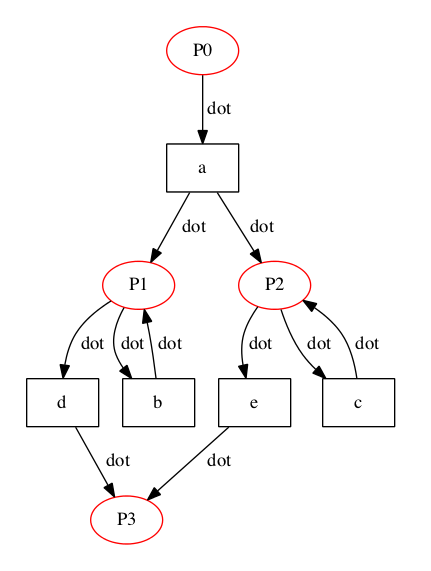

In [6]:
Image(',net-with-colors.png')